## This notebook is developed for PICES 2022

### CODAR

CODAR is a technology that allows the measurement of surface ocean current velocities at a distance using the Doppler shift of reflected radio waves. The principle of Bragg scattering dictates that virtually all of the radio signal received by a CODAR antenna is being reflected back from ocean waves of a particular wavelength. The reflected signal is Doppler-shifted to higher or lower frequencies, depending on whether the ocean wave is moving, respectively, toward or away from the antenna. In the absence of ocean currents, this Doppler shift gives a measurement of the wave spee. If ocean currents are present, however, the Doppler shift gives a measurement of the wave speed PLUS the speed of the ocean current towards or away from the antenna. Because the speed of deep-water waves is known for a given wavelength, the wave speed can be subtracted from the total measured speed, resulting in a value for the speed of the ocean current alone.

The strait of Georgia CODAR system used by ONC is a 25 MHz model. A radio frequency of 25 MHz corresponds to a radio wavelength of 12 meters, so the CODAR system is sensitive to ocean wavelengths of 6 meter. The equation used in calculating ocean current velocities from the Bragg-scattering signal assume that the ocean waves being measured are "deep-water" waves. In other words, their wavelengths are less than twice the water depth. As depth decreases beyong this point, the waves will increasingly take on the character of "shallow-water" waves. Thus that for a 25 MHz system, ocean currents measured in water depths of less than 3 meters should be viewd with suspiction.  


### CODAR stations and combiners

Each CODAR systems measures the radial velocities of ocean surface currents, toward and away from the station's attenna. The four stations have been placed in locations such that their areas of coverage overlap considerably. In the overlapping regions, it is possible to combine the radial data from at least two stations into total ocean currents. 

In the strait of Georgia, four anttennas have been gradually installed since 2011. 


Note that the range of high-frequency radio waves is greatly reduced over fresh water compared to the range over salty, highly-conductive water. For this reason, during the spring freshet (June 2018), when the surface water in the strait of Gerogia is much less sality, less coverage of total ocean current would be expected.



### Grid

The total files organize the data into grids with y,x and time dimensions, while the radials files use arrays for the current data, with dimensions of time and index, where index links the currents to their lat/lon sampling locations. The x,y dimensions are the grid centers relative to the grid origin.

The radials files from combiner stations will contain data from multiple radials stations; the platform_name variable will supply the station name / call sign (i.e. VION) for each time step. 


### Data description

MAT file data structures and definitions

This section describes the MAT file structure in detail. HFRProgs's README and code also documents these structures, so only relevant ones will be listed in detail.

**Radials:** 

a structure array containing radial surface current data. Each instance of the structure is a scan at a particular time. Details as follows:
1. U/V: surface current radial velocities as read from the .ruv files and subsequently tested and cleaned
2. LonLat: :,2 vector containing longitude and latitude pairs for each U/V value
3. Error: can be taken from the ETMP or STDV column from the RUV file (may be deprecated in the future)
4. temporalQuality: is the ETMP column from the RUV file, so it's usually a duplicate of Error
5. spatialQuality: is the ESPC column from the RUV file
6. OtherMetadata: this structure was modified from HFRProgs. We moved the ruv file Header and RawData into the Radials structure, see the next two entries:
7. ruvHeader: cell strings of the ruv file header
8. ruvRawData: matrix corresonding to the raw data body of the ruv file
9. ProcessingSteps: a cell array of char vectors (strings) reporting on the various details of the processing that was done. Tip: to get a print out of the comments, try this: char(Radials(1).ProcessingSteps) 

**Radials.QC:** 

a structure containing the overallFlag QC flag and any other flag generated by the radial tests and cleaning. Flag values of 1 are a pass, 4 is a failure/bad. The flag vectors all match the size of the U/V vectors. We've removed the Radials.Flag vector in our code as the QC structure supersedes it. QC also contains all of the test parameters, named with the same test name as the flag appended by 'TestThreshold'. Unless noted in the documentation, the tests pass if the value is less than this threshold. All test thresholds are stored as device attributes and vary by device and time. A sub-structure contains the results of the .ruv file syntax test: CheckRDLsyntax, each value in contained within describes each check and it's result, all of which must pass for the data to be included in the Radials and Totals structures. Failures are noted in the search status (visible in the Data Search cart). Syntax failures should not happen.

**Totals**

1. U/V: surface current total velocities calculated from the Radials structure
2. LonLat: :,2 vector containing longitude and latitude pairs for each U/V value
3. Uraw/Vraw: surface current total velocities as generated by loading radials, compiling by time and passing to the same configuration of makeTotals.m as done for the clean U/V. So no cleaning is done on Uraw/Vraw and the values should be very similar to the manufacturer's U/V, but may not be exactly the same due to different configuration values in makeTotals.m. These velocities may be used as a comparison to see the difference the cleaning/QC process has made to the data.



### Data included: June and Nov. 2018 for both radial data and total vectors.

1. Radial sites: VATK, VGPT, VION, VCOL
2. Totals : Strait of Georgia

### Data can be downloaded through here:
https://data.oceannetworks.ca/DataSearch?locationCode=SOGCS&deviceCategoryCode=OCEANOGRAPHICRADAR


### Programming preparation

1. Install anaconda on mac: https://docs.anaconda.com/anaconda/install/mac-os/ or windows: https://docs.anaconda.com/anaconda/install/windows/

2. Install basemap: conda install -c anaconda basemap 
3. Install higher resolution basemap: conda install -c conda-forge/label/cf201901 basemap-data-hires 
4. Install pycurrent https://currents.soest.hawaii.edu/ocn_data_analysis/installation.html



In [9]:

from hdf5storage import savemat
from hdf5storage import loadmat
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as sio
import pickle as pickle
import numpy.matlib
import numpy.ma as ma
import numpy as np
import glob
import copy
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
from fractions import Fraction
from matplotlib.pyplot import cm
import math
import datetime
import scipy.interpolate
import os
import shutil
from numpy.linalg import inv
from numpy import matmul
from numpy import multiply
from datetime import datetime
from datetime import timedelta  
import warnings
import pandas as pd
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA # need to install scikit-learn
import pytide
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib nbagg
cmap = matplotlib.cm.jet

In [10]:
import sys

In [11]:
#sys.path

In [12]:
#os.environ["TIDE_CONFIG_LOCATION"] ="/Users/manmanw/opt/anaconda3/envs/PICES2022/lib/python3.10/site-packages/tide"

In [13]:
#from pytides.tide import Tide

In [14]:
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac


def vector_log(U_raw,V_raw):
    SpeedL=np.log10(np.sqrt(U_raw**2+V_raw**2))
    Theta=np.arctan(V_raw/U_raw)
    UL=np.sign(U_raw)*SpeedL*np.abs(np.cos(Theta))
    VL=np.sign(V_raw)*SpeedL*np.abs(np.sin(Theta))
    return UL, VL    

def plotBasemap(Latmin,Latmax,Lonmin,Lonmax,Title):   
    
    M=Basemap(projection='merc', llcrnrlat=Latmin,urcrnrlat=Latmax,llcrnrlon=Lonmin,
              urcrnrlon=Lonmax,resolution='h',area_thresh = 0.01)    
    
    M.drawparallels(np.arange(48.85,49.37,0.1) ,labels=[1,0,0,0]);
    M.drawmeridians(np.arange(-123.8,-122.95,0.3),labels=[0,0,0,1]);
    M.drawmapboundary()
    M.fillcontinents(color='grey')
    
    
    plt.title(Title)
    Stationnames=['VION','VGPT','VATK','VCOL'] 
    for i,Istation in enumerate((Stationnames)):
        XO,YO=M(orig_lon[Istation],orig_lat[Istation])
        M.plot(XO,YO,'r^',markersize=10)
        plt.text(XO,YO,Istation,fontsize=14)
        plt.title(Title,fontsize=14)
    return M    

In [15]:



# Longitude and latitude of the four radar sites for plotting sites
orig_lon={}
orig_lat={}

orig_lon['VION']=-123.2053833
orig_lon['VCOL']=-123.1718833
orig_lon['VGPT']=-123.291
orig_lon['VATK']=-123.2644333
orig_lon['VDIG']=-130.4254500
orig_lon['VRID']=-130.3346833

orig_lat['VATK']=49.3300667
orig_lat['VCOL']=49.01805
orig_lat['VGPT']=48.87365
orig_lat['VION']=49.2158667
orig_lat['VDIG']=54.2625333
orig_lat['VRID']=54.2346333

# Get basemap

latmin = 48.85#48.6
latmax = 49.39#49.5
lonmin =-123.8#-124
lonmax =-122.9#-122.7

latpar_min=round(latmin*10)//10
latpar_max=round(latmax*10)//10
lonpar_min=round(lonmin*10)//10
lonpar_max=round(lonmax*10)//10



#mSOG= Basemap(projection='merc', llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin,
 #             urcrnrlon=lonmax,resolution='h',area_thresh = 0.01)    

In [16]:
# Get data files for the specific month
month='Nov'
basedir='/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/'
datafolder=basedir+'Data_PICES2022/'+month+'2018_totals_mat'
datafiles=sorted(glob.glob(datafolder+'/*.mat'))
savefigurefolder=basedir+'savefigures/'

In [17]:
datafiles

['/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181101T000000.000Z_20181115T210000.000Z-Totals_Radials_Clean.mat',
 '/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181115T220000.000Z_20181130T050000.000Z-Totals_Radials_Clean.mat',
 '/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181130T060000.000Z_20181130T230000.000Z-Totals_Radials_Clean.mat']

In [18]:
# load three mat files for the specific month and then 
u=[]
v=[]
date=[]
for i in range(len(datafiles)):
    print (i)
    print (datafiles[i])
    datai=loadmat(datafiles[i])
    num_hours=len(datai['Totals'])
    for j in range(num_hours):
        dataj=datai['Totals'][j][0]
        uj=dataj['U']
        vj=dataj['V']
        timestamp=dataj['TimeStamp'][0][0]+0.0000000001
        datej=str(matlab2datetime(np.float(timestamp)))[0:13]
        
        u=np.append(u,uj)
        v=np.append(v,vj)
        date=np.append(date,datej)
        
    lonlat=dataj['LonLat']
    

0
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181101T000000.000Z_20181115T210000.000Z-Totals_Radials_Clean.mat
1
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181115T220000.000Z_20181130T050000.000Z-Totals_Radials_Clean.mat
2
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181130T060000.000Z_20181130T230000.000Z-Totals_Radials_Clean.mat


In [19]:
# Put u and v into Pandas dataframe

lon=lonlat[:,0]
lat=lonlat[:,1]
num_hours=len(date)
u_df=pd.DataFrame(u.reshape(num_hours,len(u)//num_hours).T,index=[lon,lat],columns=date)
v_df=pd.DataFrame(v.reshape(num_hours,len(u)//num_hours).T,index=[lon,lat],columns=date)

In [20]:
u_df

,,2018-11-01 00,2018-11-01 01,2018-11-01 02,2018-11-01 03,2018-11-01 04,2018-11-01 05,2018-11-01 06,2018-11-01 07,2018-11-01 08,2018-11-01 09,...,2018-11-30 14,2018-11-30 15,2018-11-30 16,2018-11-30 17,2018-11-30 18,2018-11-30 19,2018-11-30 20,2018-11-30 21,2018-11-30 22,2018-11-30 23
-123.015064,48.788191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.001455,48.788148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.987846,48.788104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.919804,48.787858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.906195,48.787804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-123.741076,49.426560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.727292,49.426604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.713508,49.426645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.699723,49.426685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Temporal variability

In [21]:
# Calculate spatial and temporal availability
# Spatial availability=number of available hours/total hours of that month
# Temporal availability= number of data points at each hour/maximum of data points over that month
maskU_df=u_df
maskU_df=maskU_df.notnull().astype("int");
spatial_availability=maskU_df.sum(axis=1)/maskU_df.shape[1]
temp_availability=maskU_df.sum(axis=0).values/maskU_df.sum(axis=0).values.max()

max_temporal_avail=np.argmax(temp_availability)
max_spatial_avail=np.argmax(spatial_availability)

<IPython.core.display.Javascript object>


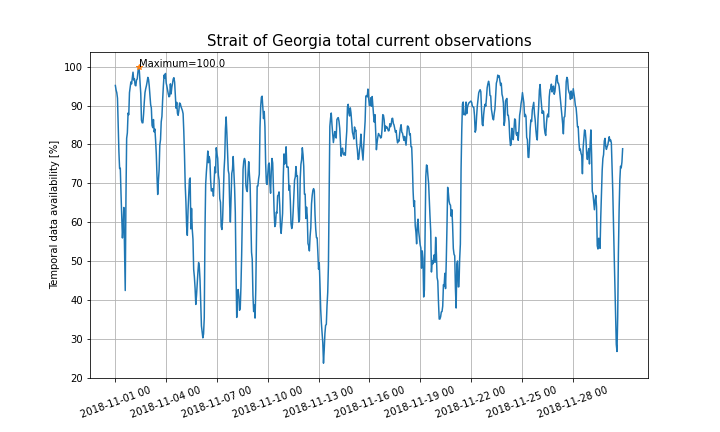

In [22]:
# Plot temporal data availability
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,6))
ax=[]

xt=np.arange(len(temp_availability))
plt.plot(xt,temp_availability*100)

plt.xticks(xt[::72],date[::72],rotation=20,fontsize=10);
plt.ylabel('Temporal data availability [%]',fontsize=10)
plt.title('Strait of Georgia total current observations',fontsize=15)
plt.grid('on')




plt.plot(xt[max_temporal_avail],temp_availability[max_temporal_avail]*100,'*')
plt.text(xt[max_temporal_avail],temp_availability[max_temporal_avail]*100,'Maximum='+str(np.max(temp_availability)*100))

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TemporalAvailability_'+str(month)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# Plot total current map

In [23]:
u_select=u_df.iloc[:,max_temporal_avail]
v_select=v_df.iloc[:,max_temporal_avail]

<IPython.core.display.Javascript object>


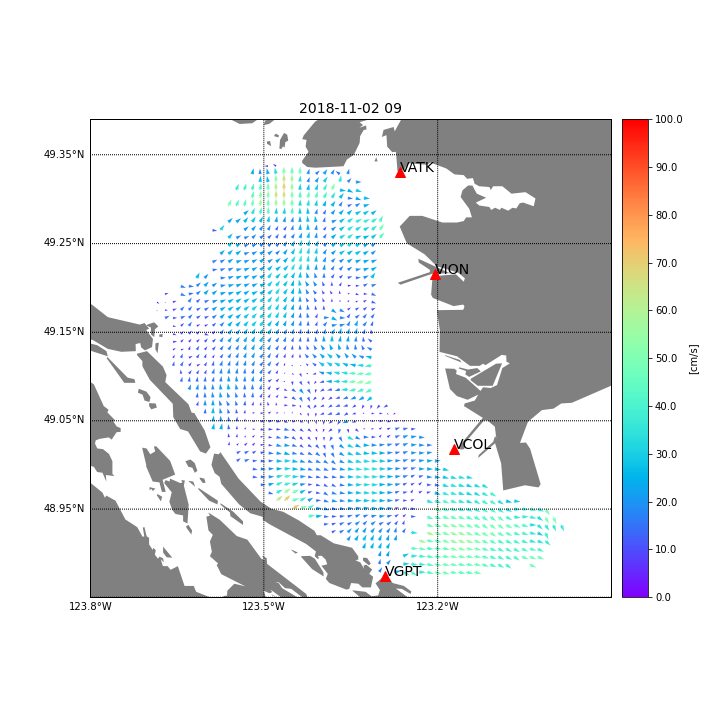

In [24]:
# Plot the total currents that has maximum data coverage during that month

u_select,v_select


fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10))
ax=axs

mSOG=plotBasemap(latmin,latmax,lonmin,lonmax,date[max_temporal_avail])

lons,lats=mSOG(lon,lat)
u,v=vector_log(u_select,v_select)
q=mSOG.quiver(lons,lats,u,v,np.sqrt(u_select**2+v_select**2),units='x',cmap=cm.rainbow)
cbar=mSOG.colorbar(q,ticks=np.arange(0,101,10),format = '%2.1f',label='[cm/s]')
q.set_clim(np.array([0,100]))

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TotalCurrent_'+date[max_temporal_avail]+str(month)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# Spatial Avaialbility 

<IPython.core.display.Javascript object>


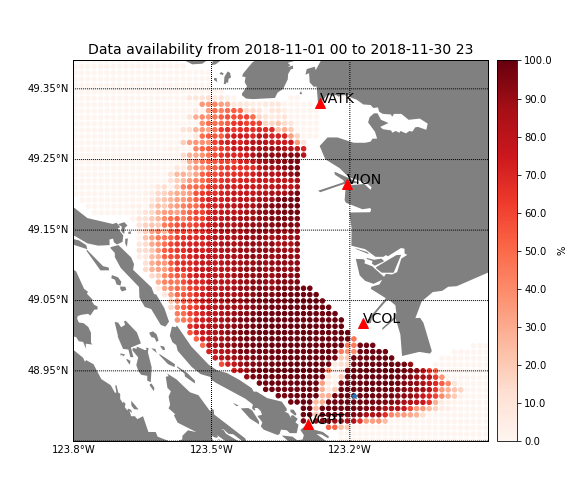

In [42]:

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
#plotBasemap(mSOG)
#plotStation('Data availability from '+date[0]+' to '+date[-1],mSOG)

mSOG=plotBasemap(latmin,latmax,lonmin,lonmax,'Data availability from '+date[0]+' to '+date[-1])



q=plt.scatter(lons,lats,c=spatial_availability.values*100,s=20,cmap='Reds')
plt.plot(lons[max_spatial_avail],lats[max_spatial_avail],'*')

cb=mSOG.colorbar(label='%' );
q.set_clim(np.array([0,100.001]))
cb.set_ticks(np.arange(0,100.001,10))
cb.set_ticklabels(np.arange(0,100.001,10))


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='SpatialAvailability_'+str(month)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 1) spectra analysis

In [91]:
# select one grid cell to do three types of analysis. this specific grid cell has maximum spatial data avaialability
# 1. rotary spectra analysis for u and v
# 2. spectra analysis for speed
# 3. pca analysis
# 4. tidal analysis

#Data need to be normalized before spectra analysis

u_cell=u_df.iloc[max_spatial_avail,:].values
v_cell=v_df.iloc[max_spatial_avail,:].values

#normalize u and v
u_cell_norm=(u_cell-np.nanmean(u_cell))/np.std(u_cell)
v_cell_norm=(v_cell-np.nanmean(v_cell))/np.std(v_cell)
vel_cell_norm=u_cell_norm+1j*v_cell_norm

#calculate speed and then normalize before spectra calculation
spd_cell=np.sqrt(u_cell**2+v_cell**2)
spd_cell_norm=(spd_cell-np.nanmean(spd_cell))/np.std(spd_cell)

#calculate spectra of velocity
ndata=len(u_cell)
nfft=256
dof=2*ndata/nfft-1
Cus,kk=mlab.psd(vel_cell_norm,Fs=1./1,NFFT=nfft,window=mlab.window_hanning,noverlap=nfft/2)

#calculate spectra of speed
Cus_spd,kk_spd=mlab.psd(spd_cell_norm,Fs=1./1,NFFT=nfft,window=mlab.window_hanning,noverlap=nfft/2)

<IPython.core.display.Javascript object>


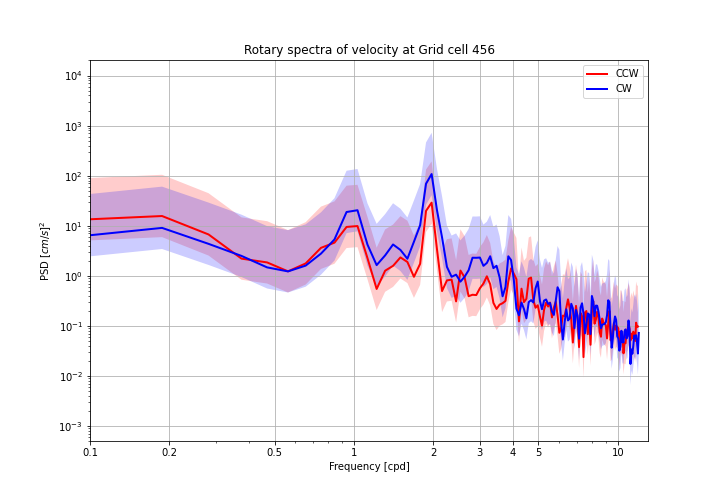

In [114]:
#plot rotary spectra

# def function of pltfill to plot the uncertainty based on degrees of freedom
def pltfill(X,Y,DOF,Col):
    Inter=stats.chi2.interval(0.95,df=DOF)
    plt.fill_between(X,DOF*(Y)/Inter[1],DOF*(Y)/Inter[0],alpha=0.2,
        linewidth=0.0,edgecolor=None,color=Col,facecolor=Col)
       


fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,7))
ax=[]

#Plot ccw
plt.plot(kk*24,Cus,label='CCW',color='r',linewidth=2);pltfill(kk*24,Cus,dof,'r')

#Plot cw
plt.plot(-kk*24,Cus,label='CW',color='blue',linewidth=2);pltfill(-kk*24,Cus,dof,'blue');

#plot spectra pf speed
#plt.plot(kk_spd*24,Cus_spd,label='Speed',linewidth=2);
#pltfill(kk_spd*24,Cus_spd,dof,'green');

plt.grid();
plt.yscale('log');
plt.xscale('log');
plt.legend();
plt.xlabel('');
plt.xlim([0.1,13]);
plt.ylim([0.0005,20000]);
plt.title('Rotary spectra of velocity at Grid cell '+str(max_spatial_avail));
plt.xticks([0.1,0.2,0.5,1,2,3,4,5,10],[0.1,0.2,0.5,1,2,3,4,5,10]);
plt.xlabel('Frequency [cpd]');
plt.ylabel('PSD '+'$[cm/s]^2$');

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='Spectra'+str(month)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 2) PCA analysis

In [110]:
#Input UU and VV data time series at a certain grid cell in format of dataframe
def pca_data(UU,VV,N_std):
    XX=pd.DataFrame({'u':UU,'v':VV}).values
    XX_meaned=XX-np.mean(XX,axis=0)
    #XX_new= pca.fit_transform(XX_meaned)
    Ppca=PCA(n_components=2).fit(XX_meaned)
    
    Angle=np.arctan(Ppca.components_[0,1]/Ppca.components_[0,0])*180/np.pi+180
    Ellipse_norm=N_std*np.sqrt(Ppca.explained_variance_)* Ppca.components_.T #normalized by number of N_std
    Ell_radius_x=np.sqrt(Ellipse_norm[0,0]**2+Ellipse_norm[1,0]**2)
    Ell_radius_y=np.sqrt(Ellipse_norm[0,1]**2+Ellipse_norm[1,1]**2)
       
    return XX_meaned,Angle,Ell_radius_x,Ell_radius_y,Ppca

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1,v0, arrowprops=arrowprops)
    
def plot_ellipse_grid(PCA,N_std,X_demeaned,Ellipse_x,Ellipse_y,Angle,Tit,Col):

    plt.scatter(X_demeaned[:, 0], X_demeaned[:, 1], color=Col,alpha=0.2,label='De_meaned')    
    e = Ellipse(xy = (0,0), width = Ellipse_x * 2, height = Ellipse_y * 2, angle=Angle,
           edgecolor='blue',facecolor='none',joinstyle='bevel',
                     linewidth=1)

    for Length, Vector in zip(PCA.explained_variance_, PCA.components_):
        VV = Vector  * np.sqrt(Length)*N_std
        draw_vector(PCA.mean_, PCA.mean_ +VV)
    
    
    Label_x=-100+13;Label_y=100-13;Scale=5
    e2 = Ellipse(xy = (Label_x,Label_y), width =Scale*2, height =Scale*2, angle=90,
               edgecolor=Col,facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                         linewidth=1)
    plt.plot([Label_x,Label_x+Scale],[Label_y,Label_y],color='black')
    ax.add_artist(e2);plt.text(Label_x-Scale-Scale/2,Label_y+Scale+Scale/2,'5cm/s') 
    
    ax.add_artist(e);plt.xlim([-100,100]);plt.ylim([-100,100])
    ax.legend(loc=3,fontsize=8)
    ax.set_xlabel('U [cm/s]',fontsize=11)
    ax.set_ylabel('V [cm/s]',fontsize=11)
    plt.axvline(x = 0,color='black',alpha=0.3)
    plt.axhline(y = 0,color='black',alpha=0.3)
    plt.text(75,-50,'$2\sigma$',fontsize=15);plt.title(Tit)

<IPython.core.display.Javascript object>


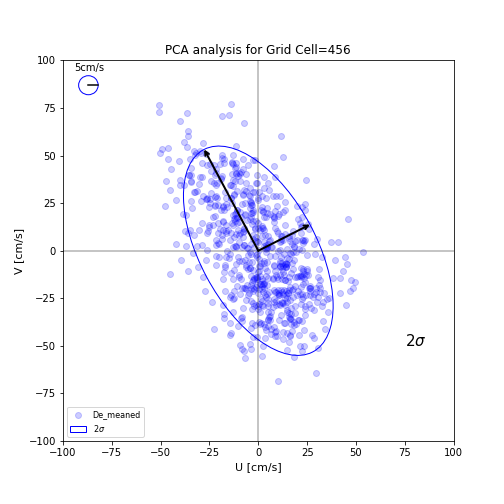

In [116]:


u_cell_nonan=u_df.iloc[max_spatial_avail,:].dropna()
v_cell_nonan=v_df.iloc[max_spatial_avail,:].dropna()
n_std=2

U_meaned_cell,angle_cell,ell_x_cell,ell_y_cell,pca_cell=pca_data(u_cell_nonan,v_cell_nonan,n_std)


fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
plot_ellipse_grid(pca_cell,n_std,U_meaned_cell,ell_x_cell,
                              ell_y_cell,angle_cell,'PCA analysis for Grid Cell='+str(max_spatial_avail),'blue')

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='PCA_Cell'+str(max_spatial_avail)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# 3) Calculate and plot the tidal analysis for one grid/site [u,v]


In [66]:
# Load tidal analysis results
outvar=['fmaj','emaj','fmin','emin','finc','einc','pha','epha']

tide_datafolder=basedir+'ttide_data_Nov/'
tidecons=loadmat(tide_datafolder+'tidecons.mat')['tidecon']
tidenames=loadmat(tide_datafolder+'tidename.mat')['nameu'].tolist()
tide=loadmat(tide_datafolder+'tides.mat')
u_tide=np.real(tide['xout'])[0]
v_tide=np.imag(tide['xout'])[0]

In [70]:
#######
# load major, minor and angle of ellipse
tide_plot=['M2  ','S2  ','K1  ','O1  ']
ellipse_major={}
ellipse_minor={}
rotation={}

for icon, con_name in enumerate(tide_plot):
    index_tide=tidenames.index(con_name)
    
    ellipse_major[con_name]=tidecons[index_tide,outvar.index('fmaj')]
    ellipse_minor[con_name]=tidecons[index_tide,outvar.index('fmin')]
    rotation[con_name]=tidecons[index_tide,outvar.index('finc')]
# if negative, CW; if postive, CCW
ellipse_minor

<IPython.core.display.Javascript object>


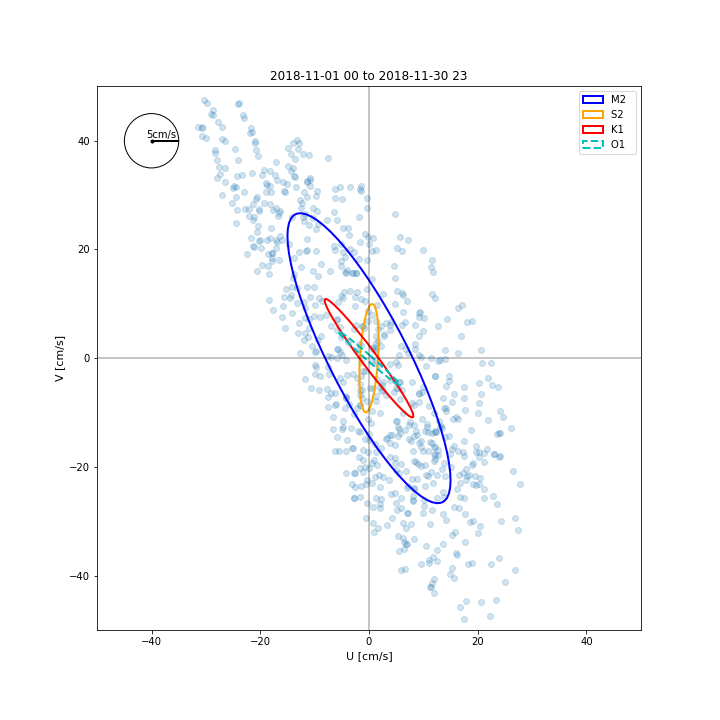

Text(0.5, 1.0, '2018-11-01 00 to 2018-11-30 23')

In [119]:
# Plot preparation
xcenter=0
ycenter=0
colors=['blue','orange','red','c']
u_tide_demeamed=u_tide-np.mean(u_tide)
v_tide_demeamed=v_tide-np.mean(v_tide)

# Plot ellipse
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10))
ax=axs
plt.scatter(u_tide_demeamed,v_tide_demeamed, alpha=0.2,)


#'M2'
itide=0
e1 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e1)

#'S2'
itide=1
e2 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e2)

#'K1'
itide=2
e3= Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2)
ax.add_artist(e3)

#'O1'
itide=3
e4 = Ellipse(xy = (xcenter,ycenter), width = ellipse_major[tide_plot[itide]]* 2, height =ellipse_minor[tide_plot[itide]]* 2, angle=rotation[tide_plot[itide]],
           edgecolor=colors[itide],facecolor='none',label=r'$2\sigma$',joinstyle='bevel',
                    linewidth=2,linestyle='--')
ax.add_artist(e4)
ax.legend([e1,e2,e3,e4],tide_plot)

# Plot measurement
cc=plt.Circle((-40,40),5,fill=False)
ax.set_aspect( 1 ) 
ax.add_artist( cc ) 
plt.plot(-40,40,'.',color='black')
ax.hlines(y=40, xmin=-40, xmax=-35, linewidth=2, color='black')
ax.text(-41,40.5,'5cm/s')



plt.xlim([-50,50]);plt.ylim([-50,50])
plt.axvline(x = 0,color='black',alpha=0.3)
plt.axhline(y = 0,color='black',alpha=0.3)
ax.set_xlabel('U [cm/s]',fontsize=11)
ax.set_ylabel('V [cm/s]',fontsize=11)
ax.set_title(date[0]+' to '+date[-1])

In [36]:
#u_tide=np.real(tide['xout'])[0]
#v_tide=np.imag(tide['xout'])[0]
#spd_tide=np.sqrt(u_tide**2+v_tide**2)

<IPython.core.display.Javascript object>


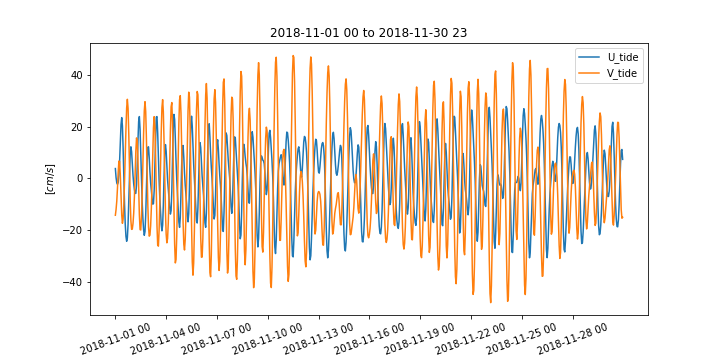

Text(0.5, 1.0, '2018-11-01 00 to 2018-11-30 23')

In [122]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,5))
ax=axs
plt.plot(u_tide,label='U_tide')
plt.plot(v_tide,label='V_tide')

plt.xticks(xt[::72],date[::72],rotation=20,fontsize=10);
plt.title('')
plt.ylabel('$[cm/s]$')
plt.legend()
ax.set_title(date[0]+' to '+date[-1])

In [136]:
Vel={'U':u_cell.values,'V':v_cell.values}
if not os.path.exists(basedir+'ttide_data_'+str(month)):
    os.makedirs(basedir+'ttide_data_'+str(month))
savemat(basedir+'ttide_data_'+str(month)+'/uv_cell.mat',Vel)

In [2]:
u_cell.values

NameError: name 'u_cell' is not defined

<IPython.core.display.Javascript object>


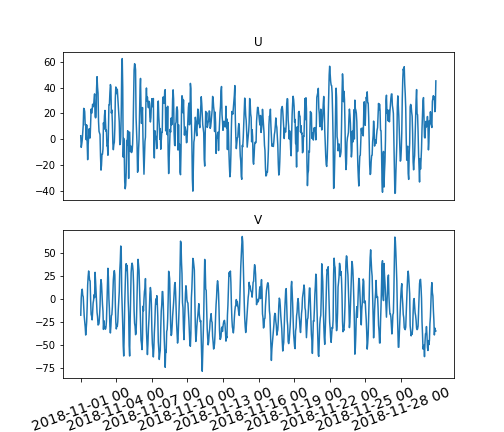

Text(0.5, 1.0, 'V')

In [110]:
# Find the location where has the maximum spatial variability value





fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,6))
ax=[]
ax.append(plt.subplot(gs2b1[0,0]))
plt.plot(u_cell)
plt.xticks([]);
plt.title('U')

ax.append(plt.subplot(gs2b1[1,0]))
plt.plot(v_cell)
plt.xticks(np.arange(len(date))[::72],date[::72],rotation=20,fontsize=14);
plt.title('V')

In [ ]:
u_df_select=u_df # not fiter out by spatial variability of 45%
maskU_df_temp=u_df_select.notnull().astype("int");
temp_var=maskU_df_temp.sum(axis=0).values/maskU_df_temp.sum(axis=0).values.max()

In [50]:

#M = Basemap(projection='merc', llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin, urcrnrlon=lonmax,
#            resolution='h',area_thresh = 0.01)    







In [26]:
u_df

,,2018-11-01 00,2018-11-01 01,2018-11-01 02,2018-11-01 03,2018-11-01 04,2018-11-01 05,2018-11-01 06,2018-11-01 07,2018-11-01 08,2018-11-01 09,...,2018-11-30 14,2018-11-30 15,2018-11-30 16,2018-11-30 17,2018-11-30 18,2018-11-30 19,2018-11-30 20,2018-11-30 21,2018-11-30 22,2018-11-30 23
-123.015064,48.788191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.001455,48.788148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.987846,48.788104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.919804,48.787858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-122.906195,48.787804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-123.741076,49.426560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.727292,49.426604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.713508,49.426645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-123.699723,49.426685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
def plotBasemap(M):   
    M.drawparallels(np.arange(-90.,91.,30.))
    M.drawmeridians(np.arange(-180.,181.,60.))
    M.drawmapboundary()
    M.fillcontinents(color='grey')

In [53]:
#Heat Map
maskU_df=u_df
maskU_df=maskU_df.notnull().astype("int");
spatial_var=maskU_df.sum(axis=1)/maskU_df.shape[1]

lons,lats=mSOG(lon,lat)

<IPython.core.display.Javascript object>


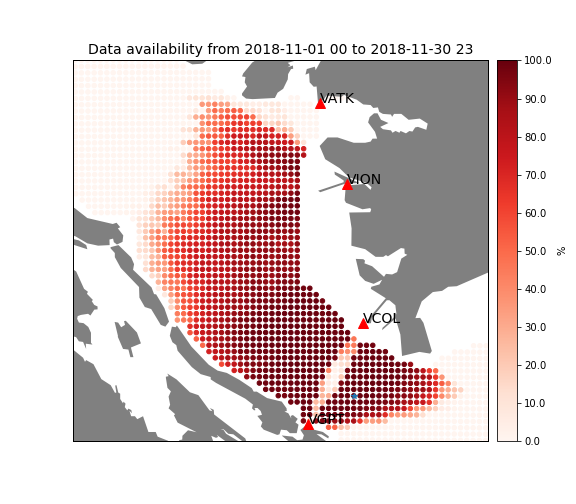

In [70]:
stationnames=['VION','VGPT','VATK','VCOL']
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
plotBasemap(mSOG)
plotStation('Data availability from '+date[0]+' to '+date[-1],mSOG)
q=plt.scatter(lons,lats,c=spatial_var.values*100,s=20,cmap='Reds')
plt.plot(lons[456],lats[456],'*')

cb=mSOG.colorbar(label='%' );
q.set_clim(np.array([0,100.001]))
cb.set_ticks(np.arange(0,100.001,10))
cb.set_ticklabels(np.arange(0,100.001,10))



<IPython.core.display.Javascript object>


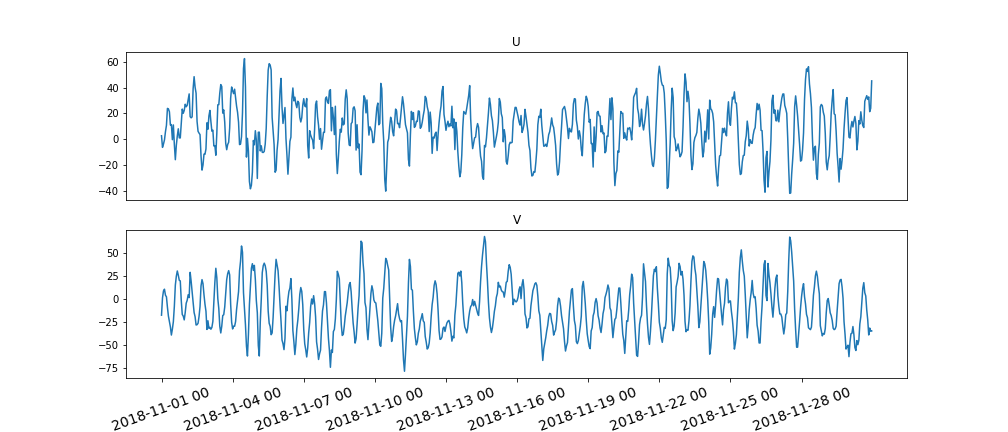

Text(0.5, 1.0, 'V')

In [60]:
np.argmax(spatial_var)

456

In [ ]:
maskU_df=u_df
maskU_df=maskU_df.notnull().astype("int");
spatial_var=maskU_df.sum(axis=1)/maskU_df.shape[1]



percent=0.0000001
index45=np.where(spatial_var>percent)[0]

maskU_dfU45=maskU_df.iloc[index45]
lons45=lons[index45]
lats45=lats[index45]

<IPython.core.display.Javascript object>


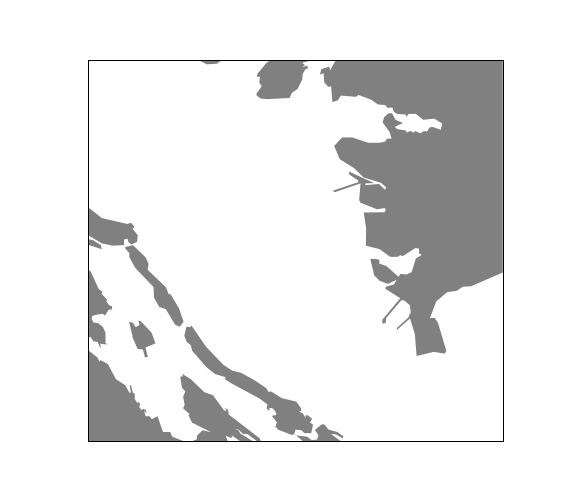

In [46]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
#m=mSOG

#plotBasemap(mSOG)

#
mSOG.drawparallels(np.arange(-90.,91.,30.));
mSOG.drawmeridians(np.arange(-180.,181.,60.));
mSOG.drawmapboundary();
mSOG.fillcontinents(color='grey');

In [9]:
#Put all data in one data_all
data_all={}
nfiles=len(datafiles)
for i in range(nfiles):
    print (i)
    print (datafiles[i])
    data_all[i]=loadmat(datafiles[i])   

0
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181101T000000.000Z_20181115T210000.000Z-Totals_Radials_Clean.mat
1
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181115T220000.000Z_20181130T050000.000Z-Totals_Radials_Clean.mat
2
/Volumes/GoogleDrive/My Drive/ConferencesWorkshops/PICES2022/Data_PICES2022/Nov2018_totals_mat/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20181130T060000.000Z_20181130T230000.000Z-Totals_Radials_Clean.mat


In [1]:
# import numpy as np
from hdf5storage import savemat
from hdf5storage import loadmat
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as sio
import pickle as pickle
import numpy.matlib
import numpy.ma as ma
import numpy as np
import glob
import copy
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
from fractions import Fraction
from matplotlib.pyplot import cm
import math
import datetime
import scipy.interpolate
import os
import shutil
from numpy.linalg import inv
from numpy import matmul
from numpy import multiply
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from datetime import timedelta  
import warnings
import pandas as pd
from pycurrents.num import spectra
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib nbagg
gs3b3 = gridspec.GridSpec(3,3)
gs1b3 = gridspec.GridSpec(1,3)
gs2b2 = gridspec.GridSpec(2,2)
gs1b1 = gridspec.GridSpec(1,1)
gs1b2 = gridspec.GridSpec(1,2)
gs2b1 = gridspec.GridSpec(2,1)
gs3b1 = gridspec.GridSpec(3,1)
cmap = matplotlib.cm.jet


orig_lon={}
orig_lat={}

orig_lon['VION']=-123.2053833
orig_lon['VCOL']=-123.1718833
orig_lon['VGPT']=-123.291
orig_lon['VATK']=-123.2644333
orig_lon['VDIG']=-130.4254500
orig_lon['VRID']=-130.3346833

orig_lat['VATK']=49.3300667
orig_lat['VCOL']=49.01805
orig_lat['VGPT']=48.87365
orig_lat['VION']=49.2158667
orig_lat['VDIG']=54.2625333
orig_lat['VRID']=54.2346333

ModuleNotFoundError: No module named 'pycurrents'

In [4]:
from ttide.t_tide import t_tide

ModuleNotFoundError: No module named 'ttide'

In [2]:
#get basemap for different regions
def getBasemap(Region):
    if Region=='PR':
        latmin = 54
        latmax = 54.5
        lonmin =-131.
        lonmax =-130
    if Region=='SOG':
        latmin = 48.85#48.6
        latmax = 49.39#49.5
        lonmin =-123.8#-124
        lonmax =-122.9#-122.7

    latpar_min=round(latmin*10)//10
    latpar_max=round(latmax*10)//10
    lonpar_min=round(lonmin*10)//10
    lonpar_max=round(lonmax*10)//10

    M = Basemap(projection='merc', llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin, urcrnrlon=lonmax,resolution='h',area_thresh = 0.01)    
    return M

###plot lines on map M
def plotBasemap(Region,M):
    if Region=='SOG':
        M.fillcontinents(color = 'grey')
        M.drawmapboundary()
        M.drawparallels(np.arange(48.85,49.37,0.1) ,labels=[1,0,0,0]);
        M.drawmeridians(np.arange(-123.8,-122.95,0.3),labels=[0,0,0,1]);
    if Region=='PR':
        M.fillcontinents(color = 'grey')
        M.drawmapboundary()
        M.drawparallels(np.arange(54,54.5,0.1) ,labels=[1,0,0,0]);
        M.drawmeridians(np.arange(-131,-130.,0.2),labels=[0,0,0,1]);   
    
def plotStation(Title,Mp):

    plt.title(Title)
    
    for i,Istation in enumerate((stationnames)):
        XO,YO=Mp(orig_lon[Istation],orig_lat[Istation])
        Mp.plot(XO,YO,'r^',markersize=10)
        plt.text(XO,YO,Istation,fontsize=14)
        plt.title(Title,fontsize=14)
        
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac


#date1st=['2018-01-01 00','2018-02-01 00','2018-03-01 00','2018-04-01 00',
#        '2018-05-01 00','2018-06-01 00','2018-07-01 00','2018-08-01 00',
#        '2018-09-01 00','2018-10-01 00','2018-11-01 00','2018-12-01 00']


def pltfill(x,y,Dof,col):
    Inter=stats.chi2.interval(0.95,df=Dof)
    plt.fill_between(x,Dof*(y)/Inter[1],Dof*(y)/Inter[0],alpha=0.2,
        linewidth=0.0,edgecolor=None,color=col,facecolor=col)
       



In [3]:
mSOG=getBasemap('SOG');
basedir='/Volumes/GoogleDrive/My Drive/Projects/MonthlyDataProduct'
datafolder=basedir+'/EllipseAnalysis'+'/Data/'

In [26]:
year=2021
month='Jan'
datafiles=sorted(glob.glob(datafolder+str(year)+'CleanTuv/'+'*.mat'))
num_datafiles=len(datafiles)

if year==2018:
    date1st=['2018-01-01 00','2018-02-01 00','2018-03-01 00','2018-04-01 00',
        '2018-05-01 00','2018-06-01 00','2018-07-01 00','2018-08-01 00',
        '2018-09-01 00','2018-10-01 00','2018-11-01 00','2018-12-01 00']
if year==2021:
    date1st=['2021-01-01 00','2021-02-01 00','2021-03-01 00','2021-04-01 00',
        '2021-05-01 00','2021-06-01 00','2021-07-01 00','2021-08-01 00',
        '2021-09-01 00','2021-10-01 00','2021-11-01 00','2021-12-01 00']

In [6]:
data_all={}
nfiles=3 # len(datafiles)
for i in range(nfiles):
    print (i)
    print (datafiles[i])
    data_all[i]=loadmat(datafiles[i])    

0
/Volumes/GoogleDrive/My Drive/Projects/EllipseAnalysis/Data/2021CleanTuv/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20210101T000000.000Z_20210114T110000.000Z-Totals_Radials_Clean.mat
1
/Volumes/GoogleDrive/My Drive/Projects/EllipseAnalysis/Data/2021CleanTuv/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20210114T120000.000Z_20210128T140000.000Z-Totals_Radials_Clean.mat
2
/Volumes/GoogleDrive/My Drive/Projects/EllipseAnalysis/Data/2021CleanTuv/StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20210128T150000.000Z_20210131T230000.000Z-Totals_Radials_Clean.mat


In [14]:

u=[]
v=[]
date=[]
num_total_files=0
for j in range(nfiles):#nfiles
    print (j)
    num_files=len(data_all[j]['Totals'])
    num_total_files=num_total_files+num_files
    
    for i in range(num_files):#num_files
        #print (i)
        datai=data_all[j]['Totals'][i][0]
        ui=datai['U']
        vi=datai['V']
        lonlat=datai['LonLat']

        timestamp=datai['TimeStamp'][0][0]+0.0000000001
        datei=str(matlab2datetime(np.float(timestamp)))[0:13]
        #print (datei)
        u=np.append(u,ui)
        v=np.append(v,vi)
        date=np.append(date,datei)
lon=lonlat[:,0]
lat=lonlat[:,1]
lons,lats=mSOG(lon,lat)

0
1
2


In [18]:

num_files=len(date)
u_df=pd.DataFrame(u.reshape(num_files,len(u)//num_files).T,index=[lon,lat],columns=date)
v_df=pd.DataFrame(v.reshape(num_files,len(u)//num_files).T,index=[lon,lat],columns=date)

In [20]:
maskU_df=u_df
maskU_df=maskU_df.notnull().astype("int");
spatial_var=maskU_df.sum(axis=1)/maskU_df.shape[1]
percent=0.0000001
index45=np.where(spatial_var>percent)[0]

maskU_dfU45=maskU_df.iloc[index45]
lons45=lons[index45]
lats45=lats[index45]

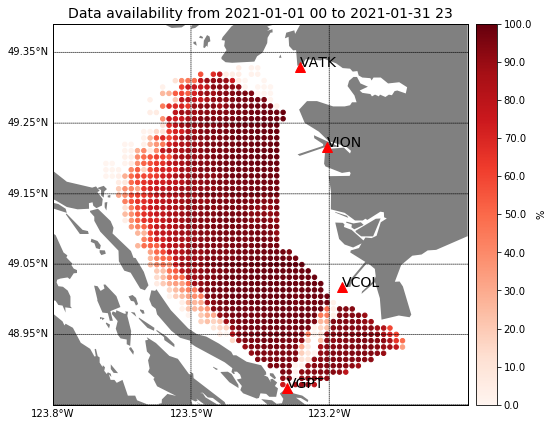

In [28]:
stationnames=['VION','VGPT','VATK','VCOL']
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
plotBasemap('SOG',mSOG)
plotStation('Data availability from '+date[0]+' to '+date[-1],mSOG)
q=plt.scatter(lons45,lats45,c=spatial_var.values[index45]*100,s=20,cmap='Reds')
#q=plt.scatter(lons,lats,c=spatial_var.values*100,s=20,cmap='Reds')
cb=mSOG.colorbar(label='%' );
q.set_clim(np.array([round(percent),100.001]))
cb.set_ticks(np.arange(round(percent),100.001,10))
cb.set_ticklabels(np.arange(round(percent),100.001,10))

savetype='heatmap_SOG'
savefigurefolder=basedir+'/savefigures/'


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='heat_map'+str(year)+str(month)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

In [33]:
u_df_select=u_df # not fiter out by spatial variability of 45%
maskU_df_temp=u_df_select.notnull().astype("int");
temp_var=maskU_df_temp.sum(axis=0).values/maskU_df_temp.sum(axis=0).values.max()

In [34]:
print ('Maximum number of grid points in '+str(year)+':')
print (maskU_df_temp.sum(axis=0).values.max())

print ('Timestamp when maximum number of grid points:')
print (maskU_df_temp.sum(axis=0).index[np.argmax(maskU_df_temp.sum(axis=0).values)])

Maximum number of grid points in 2021:
1050
Timestamp when maximum number of grid points:
2021-01-31 15


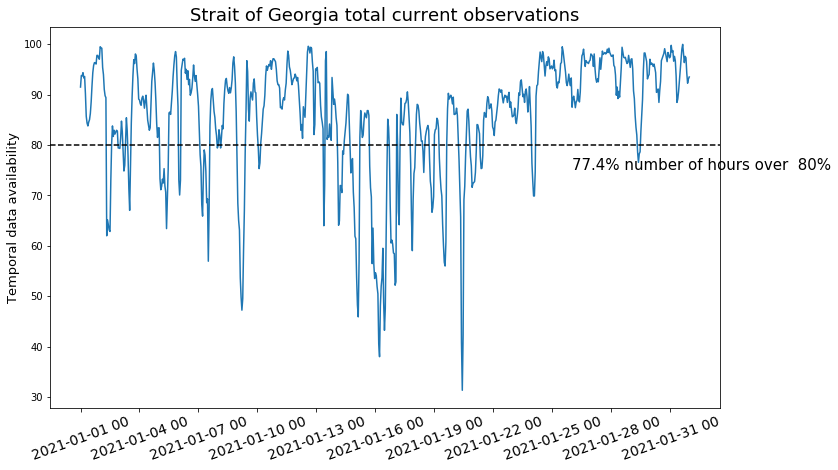

In [98]:
#Hourly temporal data availability
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(12,7))
ax=[]
plt.plot(np.arange(len(temp_var)),temp_var*100)
plt.xticks(np.arange(len(temp_var))[::72],date[::72],rotation=20,fontsize=14);
#plt.xlabel(str(year),fontsize=16)
plt.text(600,75,str(round(len(np.where(temp_var>0.8000001)[0])/len(temp_var)*100,1))+str('% number of hours over  80%'),fontsize=15)
plt.ylabel('Temporal data availability',fontsize=13)
plt.title('Strait of Georgia total current observations',fontsize=18)
plt.axhline(y=80,linestyle='--',color='black')

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TemporalAve_H'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# Diurnal signal

In [86]:
num_daily=np.ones(24)
for i in range(24):
    num_daily[i]=maskU_df.sum(axis=0)[i::24].sum()
    #print (maskU_df.sum(axis=0)[i::24])

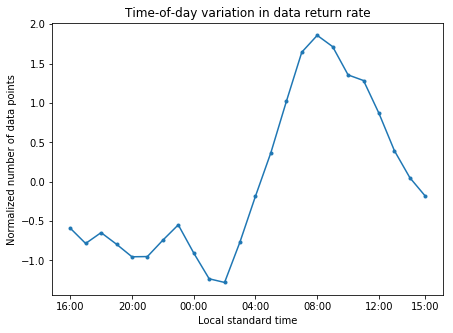

In [96]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,5))
ax=[]
plt.plot((num_daily-np.mean(num_daily))/np.std(num_daily),'.-')
plt.xticks([0,4,8,12,16,20,23],['16:00','20:00','00:00','04:00','08:00','12:00','15:00']);
plt.title('Time-of-day variation in data return rate')
plt.ylabel('Normalized number of data points')
plt.xlabel('Local standard time')

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='DiurnalSignal'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# Velocities

In [107]:
u_min=u_df.mean(axis=0)-3*u_df.std()
u_max=u_df.mean(axis=0)+3*u_df.std()

v_min=v_df.mean(axis=0)-3*v_df.std()
v_max=v_df.mean(axis=0)+3*v_df.std()

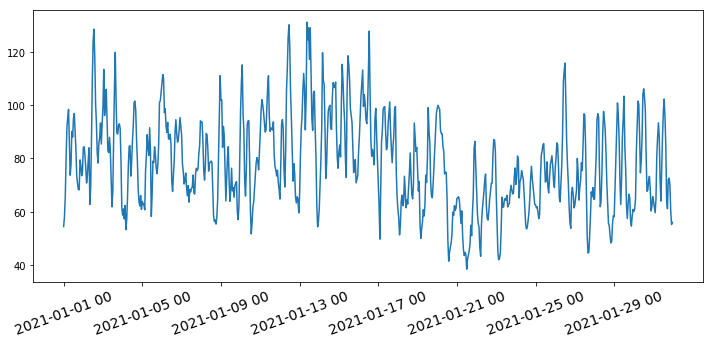

In [115]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(12,5))
ax=[]

plt.plot(np.arange(len(temp_var)),np.sqrt(u_max.values**2+v_max.values**2))
plt.xticks(np.arange(len(temp_var))[::96],date[::96],rotation=20,fontsize=14);



In [54]:
savedatafolder=basedir+'/TimeSeries_availability_SOG/data/'
timestamp=pd.to_datetime(date)
data=pd.Series(temp_var,index=pd.to_datetime(timestamp))
temp_varD=pd.DataFrame(data.resample('D').mean())
#temp_varD.to_pickle(savedatafolder+'temp_varD'+str(year)+'.pkl')

In [229]:
print ('Maximum of daily termporal availability:')
print (round(np.max(temp_varD)*100,2),'%');

print ('Minimum of daily termporal availability:')
print (round(np.min(temp_varD)*100,2),'%');

Maximum of daily termporal availability:
0    95.59
dtype: float64 %
Minimum of daily termporal availability:
0    2.66
dtype: float64 %


# load river discharge

In [145]:
#load river discharge data and then write into dataframe format.
# After saved once time, can use late using pd.read_pickle('')
#with open(savedatafolder+'08MF005_QR_Feb-16-2022_07_49_25PM.csv') as f:
#    contents_river = f.readlines()
#ntime_river=len(contents_river[11:])

#date_river=[]
#discharge=[]
#for i in range(ntime_river):
#    date_river=np.append(date_river,contents_river[11:][i][0:19])
#    discharge=np.append(discharge,float(contents[11:][i][23:-1]))
    
#save dataframe data into 
#timestamp_river=pd.to_datetime(date_river)
#dischargeDF=pd.Series(discharge,index=pd.to_datetime(timestamp_river))
#dischargeDF.to_pickle(savedatafolder+'RiverDischarge_Original.pkl')
#dischargeD=pd.DataFrame(dischargeDF.resample('D').mean())
#dischargeD.to_pickle(savedatafolder+'/RiverDischarge.pkl')

In [161]:
#load river discharge flow
dischargeD = pd.read_pickle(savedatafolder+"RiverDischarge.pkl")

# Make xticks
index_D=[]
ticks_D=[]
for i in range(12): # 365 days
    idx=np.where(dischargeD.index==date1st[i])[0]
    index_D=np.append(index_D,idx)
    ticks_D=np.append(ticks_D,date1st[i][0:7])
    
index_D=np.append(index_D,366)
ticks_D=np.append(ticks_D,'2022-01')

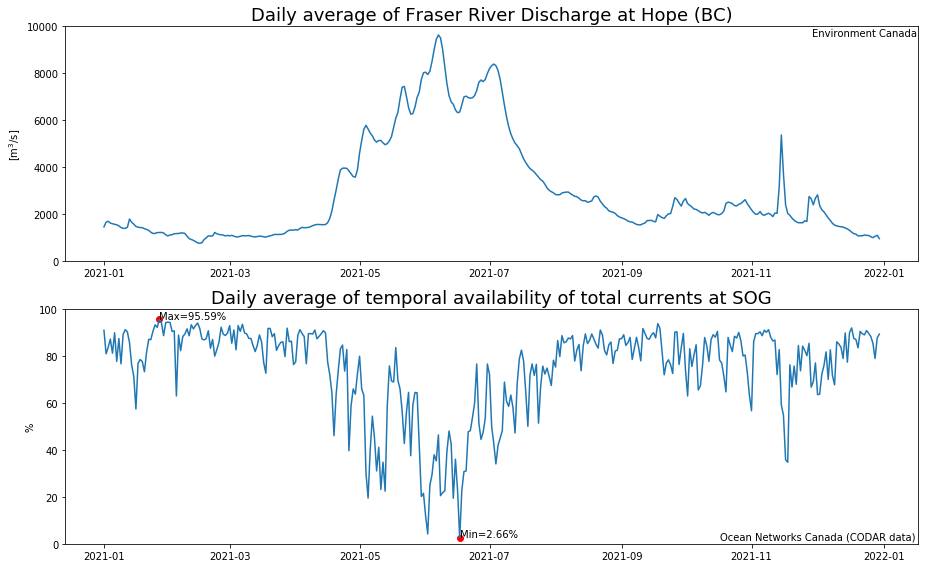

In [235]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(13,8))
ax=[]
ax.append(plt.subplot(gs2b1[0,0]))
plt.plot(np.arange(365),dischargeD.values)
plt.title('Daily average of Fraser River Discharge at Hope (BC)',fontsize=18)
plt.ylabel('[m$^3$/s]');plt.ylim([0,10000.0001])
plt.xticks(index_D[::2],ticks_D[::2])
text(365-8,10000.0001-300 ,'Environment Canada',
     horizontalalignment='center',
     verticalalignment='center', fontsize=10,color='k')

ax.append(plt.subplot(gs2b1[1,0]))
plt.plot(np.arange(365),temp_varD*100)
plt.ylim([0,100.0001])
plt.ylabel('%',fontsize=10)
plt.title('Daily average of temporal availability of total currents at SOG',fontsize=18)
plt.xticks(index_D[::2],ticks_D[::2])
text(365-30,3 ,'Ocean Networks Canada (CODAR data)',
     horizontalalignment='center',
     verticalalignment='center', fontsize=10,color='k')

#plt.scatter(np.argmax(temp_varD.values),np.max(temp_varD.values)*100,color='red')
#plt.text(np.argmax(temp_varD.values),np.max(temp_varD.values)*100,'Max='+str(round(np.max(temp_varD.values)*100,2))+'%')
#plt.scatter(np.argmin(temp_varD.values),np.min(temp_varD.values)*100,color='red')
#plt.text(np.argmin(temp_varD.values),np.min(temp_varD.values)*100,'Min='+str(round(np.min(temp_varD.values*100),2))+'%')

fig.tight_layout()
if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='RiverDischarge_tempAva'+str(2021)+'.png'
#plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#


<IPython.core.display.Javascript object>


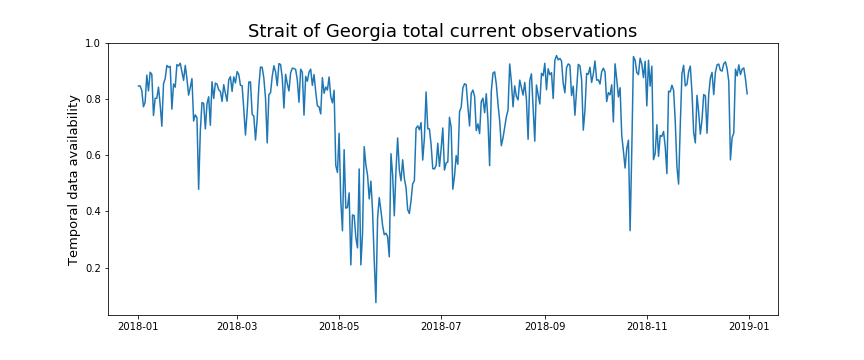

In [214]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(12,5))
ax=[]
plt.plot(temp_varD)

#plt.xlabel(str(year),fontsize=16)
plt.ylabel('Temporal data availability',fontsize=13)
plt.title('Strait of Georgia total current observations',fontsize=18)

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='TemporalAveD'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# day pass filter

Statistics of Velocity

In [13]:
v_df_select=v_df.iloc[index45]
velo=np.sqrt(u_df_select**2+v_df_select**2)
velo_mean=velo.mean(axis=0)

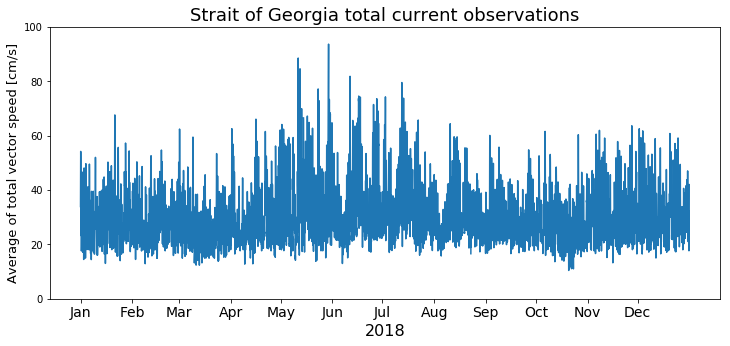

In [14]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(12,5))
ax=[]
plt.plot(np.arange(len(velo_mean)),velo_mean)
plt.xticks(np.arange(len(velo_mean))[index1st.astype(int)],monthname,fontsize=14);

plt.xlabel(str(year),fontsize=16)
plt.ylabel('Average of total vector speed [cm/s]',fontsize=13)
plt.title('Strait of Georgia total current observations',fontsize=18)
plt.ylim([0,100])

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='Velo45'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

# calculate rotary spectra

Fourier transform maps n complex numbers in the domain into n complex numbers in the frequency domain.
For each fourier frequency magnitude, the positive and negative frequency amplitudes correspond to rotation of the vector in the positive and negative direction with time.

- select locations where availability is over 85%
- Do interoplation and then calculate the rotary spectra


In [15]:
percent=0.8500001
index85=np.where(spatial_var>percent)[0]

maskU_dfU85=maskU_df.iloc[index85]
lons85=lons[index85]
lats85=lats[index85]

u_df_select85=u_df.iloc[index85]
v_df_select85=v_df.iloc[index85]


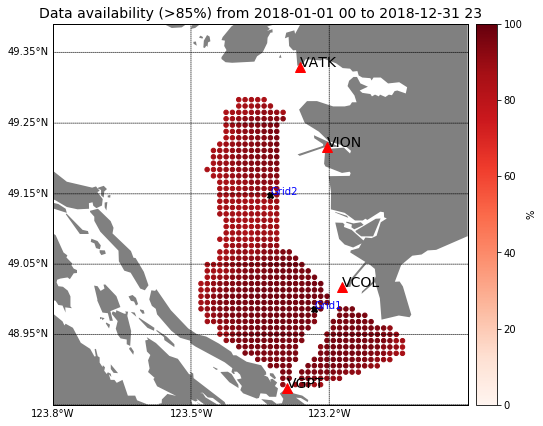

In [34]:
stationnames=['VION','VGPT','VATK','VCOL']
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,7))
ax=[]
plotBasemap('SOG',mSOG)
plotStation('Data availability (>'+str(round(percent*100))+'%) from '+date[0]+' to '+date[-1],mSOG)
q=plt.scatter(lons85,lats85,c=spatial_var.values[index85]*100,s=20,cmap='Reds')
#q=plt.scatter(lons,lats,c=spatial_var.values*100,s=20,cmap='Reds')
mSOG.colorbar(label='%' );
q.set_clim(np.array([0,100]))

iloc=253
grid_num=1
plt.plot(lons85[iloc],lats85[iloc],'X',color='black')
plt.text(lons85[iloc],lats85[iloc],'Grid'+str(grid_num),color='blue')

iloc=500
grid_num=2
plt.plot(lons85[iloc],lats85[iloc],'X',color='black')
plt.text(lons85[iloc],lats85[iloc],'Grid'+str(grid_num),color='blue')


savetype='heatmap_SOG'
savefigurefolder=basedir+'/TimeSeries_availability_SOG/savefigures/'


if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='heat_map85_'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#

In [17]:
print (lon[140],lat[140])
print (lon[250],lat[250])

-123.0692303 48.8333069
-122.9736719 48.8599953


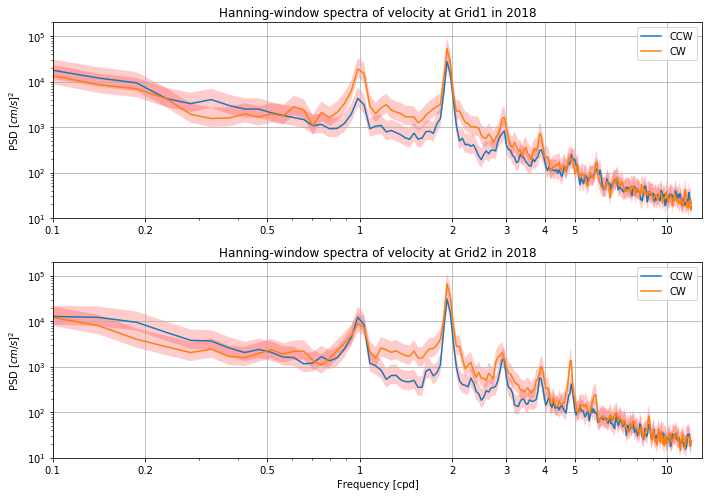

In [32]:
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,7))
ax=[]
iloc=140
grid_num=1
ax.append(plt.subplot(gs2b1[0,0]))  

u_interp=u_df_select85.iloc[iloc].interpolate()
v_interp=v_df_select85.iloc[iloc].interpolate()
vel_interp=u_interp+1j*v_interp
s = spectra.spectrum(vel_interp, nfft=None, dt=1/24, 
                     window='quadratic',
                     smooth=3)

ndata=len(vel_interp)
nfft=512
Cus,kk=mlab.psd(vel_interp,Fs=1./1,NFFT=nfft,window=mlab.window_hanning,noverlap=nfft/2)
dof=2*ndata/nfft-1

# plot

plt.plot(kk*24,Cus,label='CCW');
pltfill(kk*24,Cus,dof,'r');

plt.plot(-kk*24,Cus,label='CW');
pltfill(-kk*24,Cus,dof,'r');


plt.ylabel('PSD '+'$[cm/s]^2$');
plt.xlabel('');
plt.xlim([0.1,13]);
plt.ylim([10,200000]);

plt.grid();
plt.yscale('log');
plt.xscale('log');
plt.legend();
plt.title('Hanning-window spectra of velocity at Grid'+str(grid_num)+' in ' +str(year));
plt.xticks([0.1,0.2,0.5,1,2,3,4,5,10],[0.1,0.2,0.5,1,2,3,4,5,10]);

#####
iloc=250
grid_num=2
ax.append(plt.subplot(gs2b1[1,0]))  

u_interp=u_df_select85.iloc[iloc].interpolate()
v_interp=v_df_select85.iloc[iloc].interpolate()
vel_interp=u_interp+1j*v_interp
s = spectra.spectrum(vel_interp, nfft=None, dt=1/24, 
                     window='quadratic',
                     smooth=3)

ndata=len(vel_interp)
nfft=512
Cus,kk=mlab.psd(vel_interp,Fs=1./1,NFFT=nfft,window=mlab.window_hanning,noverlap=nfft/2)
dof=2*ndata/nfft-1

# plot

plt.plot(kk*24,Cus,label='CCW');
pltfill(kk*24,Cus,dof,'r');

plt.plot(-kk*24,Cus,label='CW');
pltfill(-kk*24,Cus,dof,'r');


plt.ylabel('PSD '+'$[cm/s]^2$');
plt.xlabel('');
plt.xlim([0.1,13]);
plt.ylim([10,200000]);

plt.grid();
plt.yscale('log');
plt.xscale('log');
plt.legend();

plt.xticks([0.1,0.2,0.5,1,2,3,4,5,10],[0.1,0.2,0.5,1,2,3,4,5,10]);
plt.xlabel('Frequency [cpd]');
plt.title('Hanning-window spectra of velocity at Grid'+str(grid_num)+' in ' +str(year));

fig.tight_layout()

if not os.path.exists(savefigurefolder):
    os.makedirs(savefigurefolder)
savefilename='Spectral_'+str(year)+'.png'
plt.savefig(os.path.join(savefigurefolder,savefilename),format='png',dpi=300)#


In [33]:
datasave={}
datasave['temp_var']=temp_var
datasave['u']=u_df.values
datasave['v']=v_df.values
datasave['lon']=lon
datasave['lat']=lat

savedatafolder=basedir+'/TimeSeries_availability_SOG/data/data'+str(year)
savemat(savedatafolder,datasave)

In [92]:
savedatafolder=basedir+'/TimeSeries_availability_SOG/data/data'+str(year)

In [93]:
savedatafolder

'/Volumes/GoogleDrive/My Drive/Projects/TimeSeries_availability_SOG/data/data2018'

In [180]:
#save data
temp_varibility={}
temp_varibility['2018']=temp_var
savedatafolder=basedir+'/TimeSeries_availability_SOG/data/temp_varibility'
savemat(savedatafolder,temp_varibility)